# [Media Campaign Cost Prediction](https://www.kaggle.com/competitions/playground-series-s3e11/data?select=train.csv)

Kaggle's Playground Series - Season 3, Episode 11 competition. Task is to devise a Machine Learning Model that helps predict the cost of media campaigns in the food marts on the basis of the features provided. This notebook used CatBoost Regressor algorithm with some hyperparameter tweaking, easy to follow. Even though it didn't have a great score, it wasn't so computer demanding and it's a good place to start.

## Dataset Description

>**store_sales(in millions)** - store_sales(in million dollars) <br>
**unit_sales(in millions)** - unit_sales(in millions) in stores Quantity <br>
**Total_children** - TOTAL CHILDREN IN HOME <br>
**avg_cars_at home(approx)** - avg_cars_at home(approx) <br>
**Num_children_at_home** - num_children_at_home AS PER CUSTOMERS FILLED DETAILS <br>
**Gross_weight** - gross_weight OF ITEM <br>
**Recyclable_package** - FOOD ITEM IS recyclable_package <br>
**Low_fat** - LOW_FAT FOOD ITEM IS LOW FAT <br>
**Units_per_case** - UNITS/CASE UNITS AVAILABLE IN EACH STORE SHELVES <br>
**Store_sqft** - STORE AREA AVAILABLE IN SQFT <br>
**Coffee_bar** - COFFEE BAR available in store <br>
**Video_store** - VIDEO STORE/gaming store available <br>
**Salad_bar** - SALAD BAR available in store <br>
**Prepared_food** - food prepared available in store <br>
**Florist** - flower shelves available in store <br>
**Cost** - COST ON ACQUIRING A CUSTOMERS in dollars <br>



In [1]:
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} took {end_time - start_time:.2f} seconds to execute.")
        return result
    return wrapper

___

## First Look at the Data

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

In [3]:
# Loading the data
df = pd.read_csv("data/playground-series-s3e11/train.csv")

In [4]:
# Dropping "id" column
df.drop("id", axis=1, inplace=True)

In [5]:
# First 5 rows
df.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [6]:
# Total rows and column dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    360336 non-null  float64
 1   unit_sales(in millions)     360336 non-null  float64
 2   total_children              360336 non-null  float64
 3   num_children_at_home        360336 non-null  float64
 4   avg_cars_at home(approx).1  360336 non-null  float64
 5   gross_weight                360336 non-null  float64
 6   recyclable_package          360336 non-null  float64
 7   low_fat                     360336 non-null  float64
 8   units_per_case              360336 non-null  float64
 9   store_sqft                  360336 non-null  float64
 10  coffee_bar                  360336 non-null  float64
 11  video_store                 360336 non-null  float64
 12  salad_bar                   360336 non-null  float64
 13  prepared_food 

We don't have missing values in the dataset. Now let's look at some summary statistics.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_sales(in millions),360336.0,6.337376,3.307980,0.51,3.72,5.78,8.40,22.92
unit_sales(in millions),360336.0,3.043881,0.784676,1.00,3.00,3.00,4.00,6.00
total_children,360336.0,2.456482,1.488992,0.00,1.00,2.00,4.00,5.00
num_children_at_home,360336.0,0.689390,1.214732,0.00,0.00,0.00,1.00,5.00
avg_cars_at home(approx).1,360336.0,2.203813,1.084293,0.00,1.00,2.00,3.00,4.00
gross_weight,360336.0,13.822071,4.614792,6.00,9.71,13.60,17.70,21.90
recyclable_package,360336.0,0.568086,0.495343,0.00,0.00,1.00,1.00,1.00
low_fat,360336.0,0.327797,0.469411,0.00,0.00,0.00,1.00,1.00
units_per_case,360336.0,18.972706,10.212912,1.00,10.00,20.00,28.00,36.00
store_sqft,360336.0,28180.333442,5968.874074,20319.00,23593.00,27694.00,33858.00,39696.00


`store_sqft` has some high values compared to the other columns. Maybe later we should normalize them before running algorithms. Let's look at how the variables are distributed.

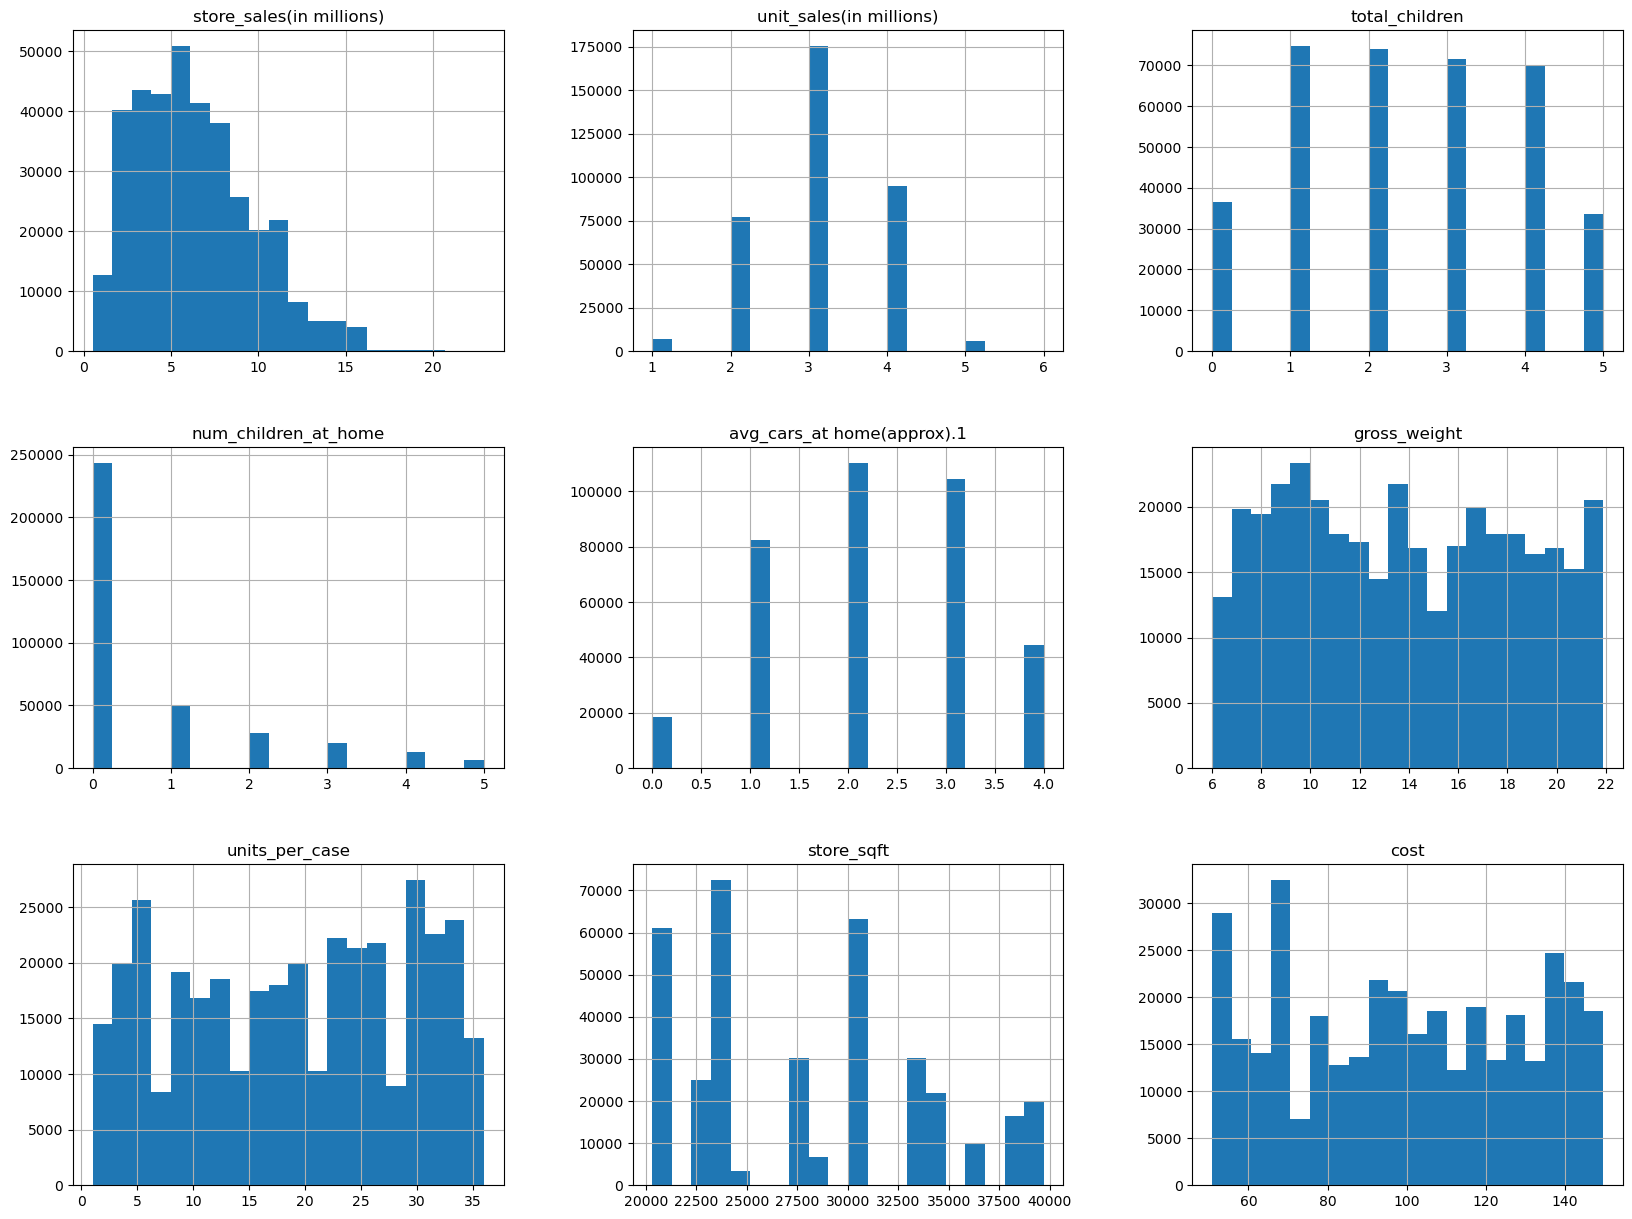

In [8]:
df[["store_sales(in millions)", "unit_sales(in millions)", 
    "total_children", "num_children_at_home", "avg_cars_at home(approx).1",
    "gross_weight", "units_per_case",
    "store_sqft", "cost"]].hist(bins = 20, figsize = (20, 15))
plt.show()

We have 6 dummy variables. This is how they're distributed.

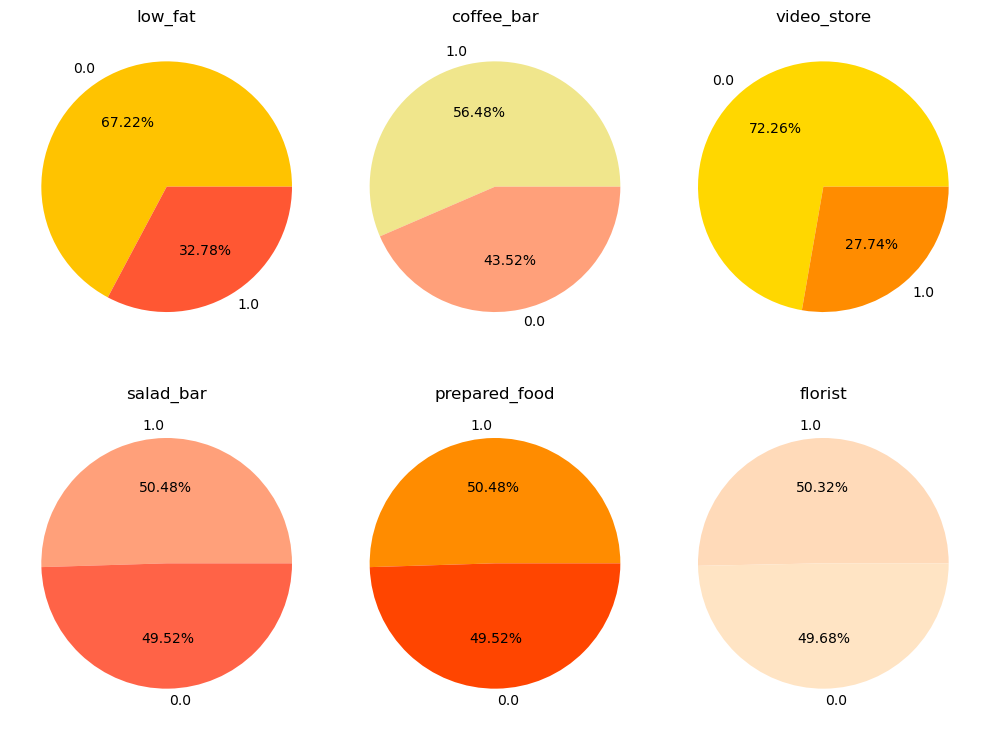

In [9]:
# Selecting the dummy variables
data = df[['low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']]

# Color palette for each plot
colors = {
    'low_fat': ['#FFC300', '#FF5733'],
    'coffee_bar': ['#F0E68C', '#FFA07A'],
    'video_store': ['#FFD700', '#FF8C00'],
    'salad_bar': ['#FFA07A', '#FF6347'],
    'prepared_food': ['#FF8C00', '#FF4500'],
    'florist': ['#FFDAB9', '#FFE4C4']
}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

# Plot a pie chart for each variable
for i, ax in enumerate(axes.flat):
    if i < len(data.columns):
        variable = data.columns[i]
        colors_i = colors[variable]
        values = data[variable].value_counts().values
        labels = data[variable].value_counts().index
        ax.pie(values, labels=labels, colors=colors_i, autopct='%1.2f%%')
        ax.set_title(variable)

plt.tight_layout()
plt.show()

## Outlier Investigation

Looking at the histogram for `store_sales(in millions)`, we can see a few values above 15 millions that might be outliers. Plotting the boxplot, we have:

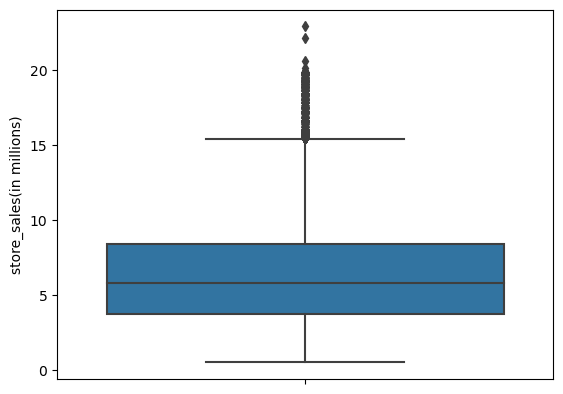

In [10]:
sns.boxplot(data=df, y="store_sales(in millions)")
plt.show()

Looking at the numbers:

In [11]:
# Find the 75th and 25th percentiles and the IQR
q75 = df["store_sales(in millions)"].quantile(0.75)
q25 = df["store_sales(in millions)"].quantile(0.25)
iqr = q75 - q25

# Calculate the thresholds
upper = q75 + (1.5 * iqr)
lower = q25 - (1.5 * iqr)

print(f"Numbers below {lower:.2f} or above {upper} can be considered outliers.")

Numbers below -3.30 or above 15.42 can be considered outliers.


As we don't have negative values, only store sales above 15.42 are outliers. Let's see how many of them.

In [12]:
n_outliers = len(df[df["store_sales(in millions)"] > upper])
print(n_outliers)

3442


3442 outliers. Which corresponds...

In [13]:
pct_total = n_outliers / len(df)
print(f"{n_outliers} outliers correspond to {(pct_total * 100):.2f}% of the base.")

3442 outliers correspond to 0.96% of the base.


Since it's a small percent, maybe it's worth it to take them out. Let's suppose we did that, how would the histogram look?

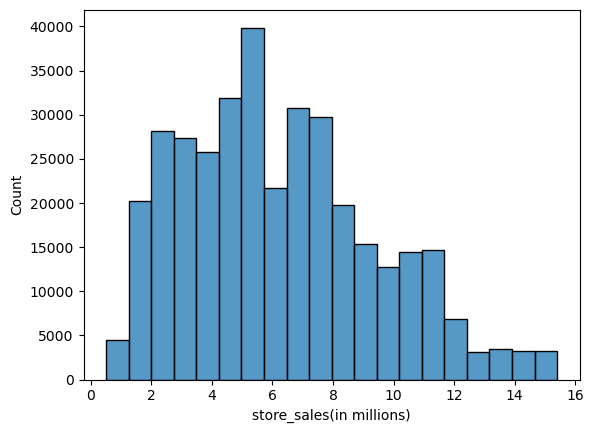

In [14]:
no_outlier_store_sales = df[df["store_sales(in millions)"] < upper][["store_sales(in millions)"]]
sns.histplot(data=no_outlier_store_sales, x="store_sales(in millions)", bins = 20)
plt.show()

The variable does look better. Let's do it for the main data.

In [15]:
df = df[df["store_sales(in millions)"] < upper]

Maybe we should investigate the other variables?

In [16]:
for i in ["gross_weight", "units_per_case", "store_sqft"]:
    # Find the 75th and 25th percentiles and the IQR
    q75 = df[i].quantile(0.75)
    q25 = df[i].quantile(0.25)
    iqr = q75 - q25

    # Calculate the thresholds
    upper = q75 + (1.5 * iqr)
    lower = q25 - (1.5 * iqr)
    
    n_outliers = len(df[(df[i] > upper) & (df[i] > upper)])
    pct_total = n_outliers / len(df)
    

    print(f"{i}: below {lower:.2f} or above {upper:.2f}.")
    print(f"{n_outliers} outliers: {(pct_total * 100):.2f}% of the total data.")
    print()

gross_weight: below -2.27 or above 29.68.
0 outliers: 0.00% of the total data.

units_per_case: below -17.00 or above 55.00.
0 outliers: 0.00% of the total data.

store_sqft: below 8195.50 or above 49255.50.
0 outliers: 0.00% of the total data.



No outliers.

___

## Correlations

As we're trying to predict the `cost` variable, it makes sense to look at how this target variable correlates with the others in the database. Let's put aside the `id` and dummy variables for a second.

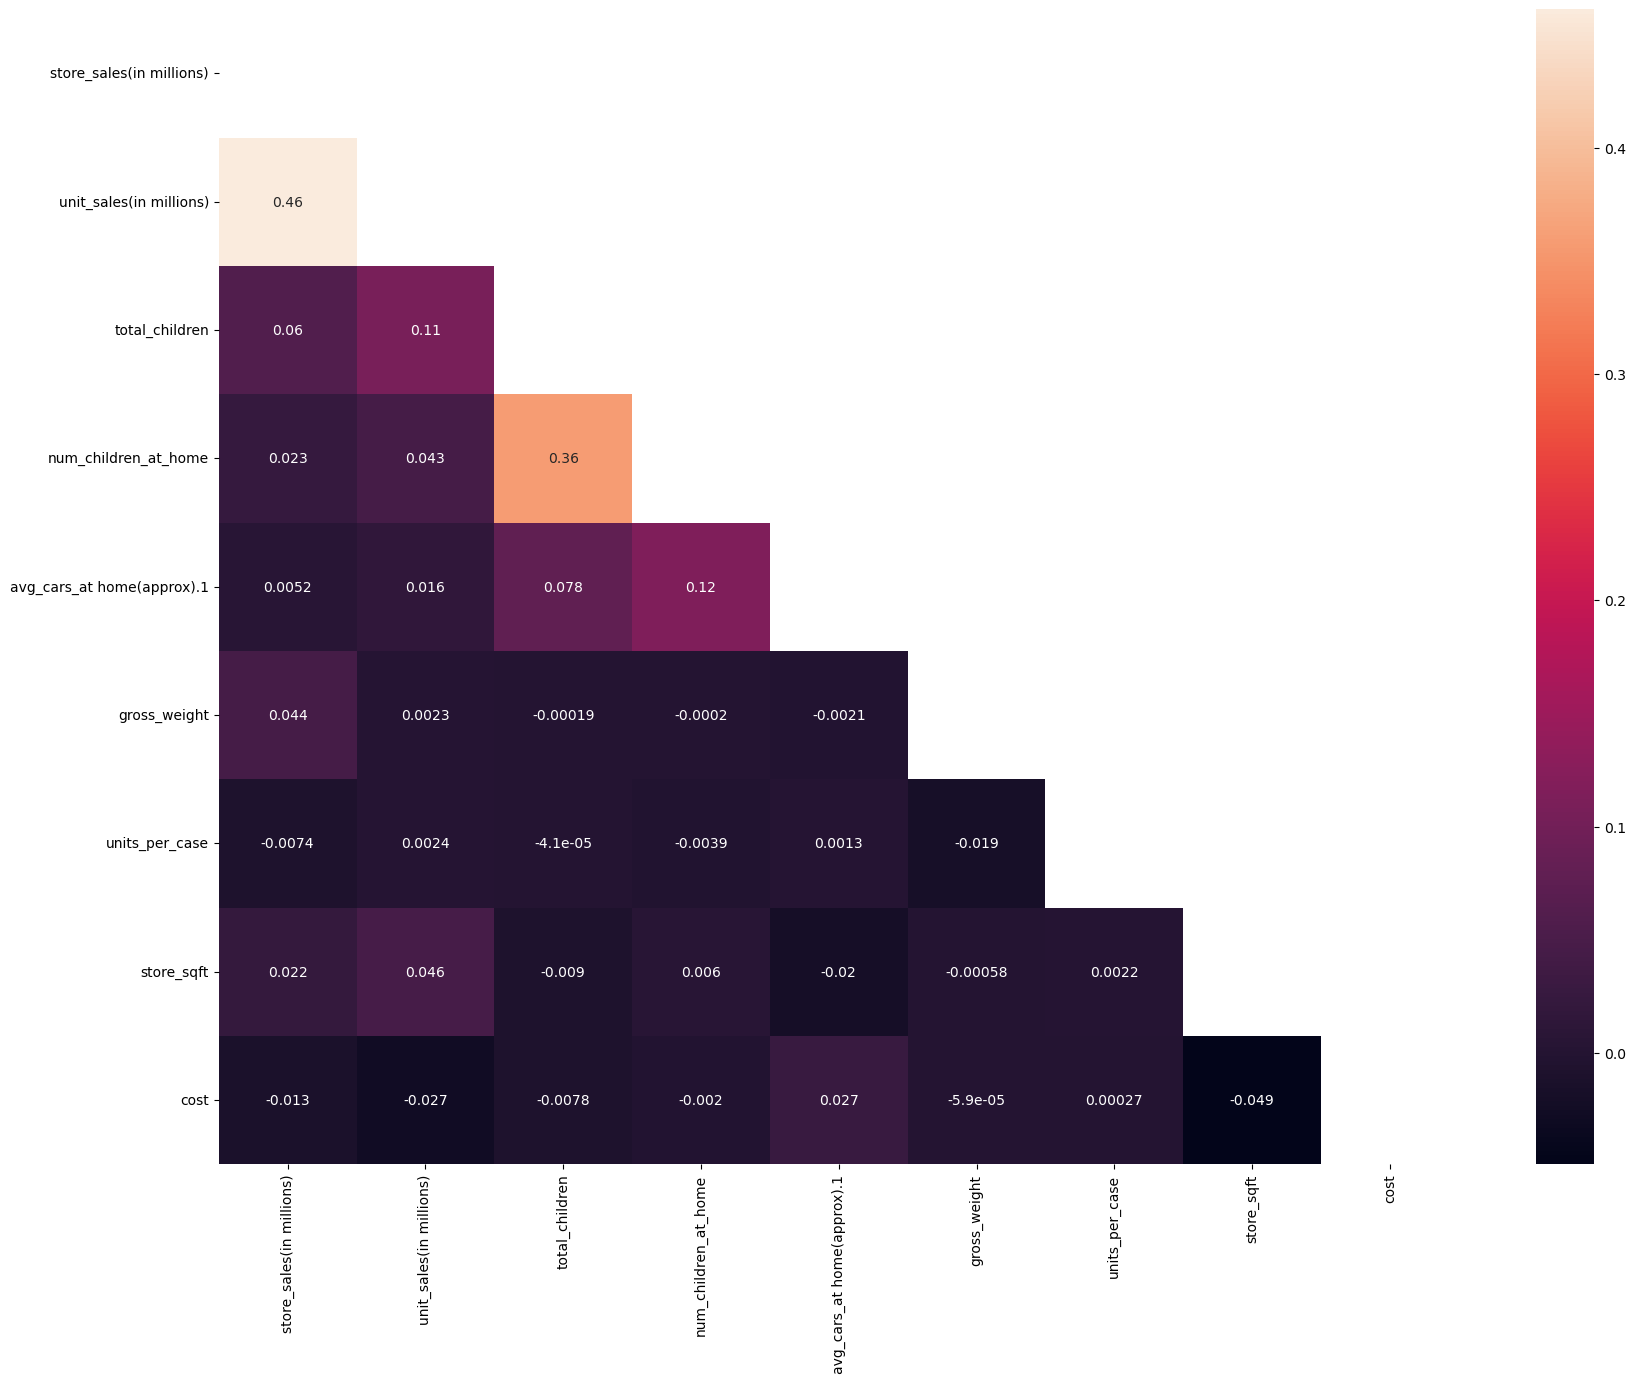

In [17]:
correl = df.drop(["recyclable_package", "low_fat", "coffee_bar", "video_store", 
                     "salad_bar", "prepared_food", "florist"], axis=1).corr()

plt.figure(figsize=(20,15))
sns.heatmap(correl, annot=True, mask=np.triu(correl))
plt.show()

Those are some very low correlations. For `cost` the highest correlations are $|0.049|$ with `store_sqft`, followed by $|0.027|$ with both average cars at home and unit sales. Also, there aren't two variables with very high correlations, which it means we could basically drop one of them.

What if we try to create some variables? For example,

- `units_per_area`: Unit sales divided by the store area.
- `weight_per_unit`: Weight per unit divided by the sales.
- `cars_minus_kids`: Average cars minus the number of children at home.

In [18]:
# Make a df copy before manipulation
original_df = df.copy()

df["units_per_area"] = df["unit_sales(in millions)"] / df["store_sqft"]
df["weight_per_unit"] = df["gross_weight"] / df["unit_sales(in millions)"]
df["cars_minus_kids"] = df["avg_cars_at home(approx).1"] - df["num_children_at_home"]

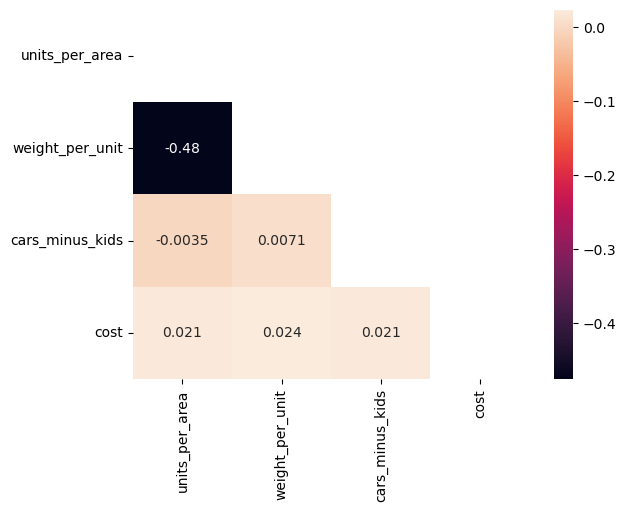

In [19]:
correl = df[["units_per_area", "weight_per_unit",
            "cars_minus_kids", "cost"]].corr()

# plt.figure(figsize=(20,15))
sns.heatmap(correl, annot=True, mask=np.triu(correl))
plt.show()

It's not very high, but it's higher than other variables in the dataset. Let's keep them.

___

## Data Transformation

Let's use scikit-learn's Standard Scaler in all, except the dummy variables and the target one.

In [20]:
dfTransform = df.drop(['low_fat', 'coffee_bar', 'video_store', 'salad_bar', 
                       'prepared_food', 'florist', 'cost'], axis=1)

In [21]:
for i in dfTransform.columns:
    dfTransform[i] = StandardScaler().fit_transform(dfTransform[[i]])

In [22]:
dfTransform.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,units_per_case,store_sqft,units_per_area,weight_per_unit,cars_minus_kids
0,0.746989,-0.041184,-0.302881,1.084217,-0.187430,-0.764741,0.872107,1.274483,1.395742,-0.809217,-0.619664,-0.991234
1,-0.391247,-1.326907,1.041194,-0.566927,0.734794,-1.553906,0.872107,-1.760637,0.004471,-1.113127,-0.661697,0.969627
2,2.471684,1.244539,-1.646956,-0.566927,0.734794,1.620099,0.872107,0.687040,-1.166957,2.060673,0.149813,0.969627
3,-0.700242,-0.041184,1.713231,-0.566927,-2.031877,0.210875,-1.146649,1.666111,-1.166957,0.788971,-0.009506,-0.991234
4,-1.296160,-0.041184,1.713231,-0.566927,0.734794,0.687843,0.872107,0.099598,-0.081321,-0.103572,0.288793,0.969627


In [23]:
df = pd.concat([dfTransform, df[['low_fat', 'coffee_bar', 'video_store', 'salad_bar', 
                       'prepared_food', 'florist', 'cost']]], axis=1)

In [24]:
df.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,units_per_case,store_sqft,units_per_area,weight_per_unit,cars_minus_kids,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0.746989,-0.041184,-0.302881,1.084217,-0.187430,-0.764741,0.872107,1.274483,1.395742,-0.809217,-0.619664,-0.991234,0.0,0.0,0.0,0.0,0.0,0.0,62.09
1,-0.391247,-1.326907,1.041194,-0.566927,0.734794,-1.553906,0.872107,-1.760637,0.004471,-1.113127,-0.661697,0.969627,0.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2.471684,1.244539,-1.646956,-0.566927,0.734794,1.620099,0.872107,0.687040,-1.166957,2.060673,0.149813,0.969627,0.0,1.0,0.0,0.0,0.0,0.0,83.51
3,-0.700242,-0.041184,1.713231,-0.566927,-2.031877,0.210875,-1.146649,1.666111,-1.166957,0.788971,-0.009506,-0.991234,1.0,1.0,0.0,0.0,0.0,0.0,66.78
4,-1.296160,-0.041184,1.713231,-0.566927,0.734794,0.687843,0.872107,0.099598,-0.081321,-0.103572,0.288793,0.969627,1.0,1.0,1.0,1.0,1.0,1.0,111.51


Now let's split the training/test set.

In [25]:
# Define your X and y variables (features and target)
X = df.drop(['cost'], axis=1)
y = df['cost']

# split the data into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

And finally, let's load the test dataframe and create the new columns as well.

In [26]:
test = pd.read_csv("data/playground-series-s3e11/test.csv")

In [27]:
test_id = test["id"]

In [28]:
test["units_per_area"] = test["unit_sales(in millions)"] / test["store_sqft"]
test["weight_per_unit"] = test["gross_weight"] / test["unit_sales(in millions)"]
test["cars_minus_kids"] = test["avg_cars_at home(approx).1"] - test["num_children_at_home"]

In [29]:
# Reorder the columns
test = test.reindex(columns=X_train.columns)

In [30]:
dfTransform = test.drop(['low_fat', 'coffee_bar', 'video_store', 'salad_bar', 
                       'prepared_food', 'florist'], axis=1)

In [31]:
for i in dfTransform.columns:
    test[i] = StandardScaler().fit_transform(dfTransform[[i]])

In [32]:
test.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,units_per_case,store_sqft,units_per_area,weight_per_unit,cars_minus_kids,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist
0,0.267941,1.221065,-0.977563,-0.565792,-0.182627,-0.655005,-1.141405,-1.170683,-1.314867,2.260860,-0.906527,0.317895,1.0,0.0,0.0,0.0,0.0,0.0
1,0.165141,-1.333277,-0.305254,1.085237,0.738924,-1.150306,0.876113,-1.464335,0.951271,-1.437352,-0.278475,-0.334588,0.0,1.0,0.0,1.0,1.0,1.0
2,0.600529,-0.056106,-1.649871,-0.565792,0.738924,-1.094071,-1.141405,-0.485497,1.928427,-0.994389,-0.816324,0.970377,1.0,0.0,0.0,1.0,1.0,0.0
3,-0.264200,-1.333277,0.367054,1.910751,-0.182627,1.745801,0.876113,-0.974916,-0.750969,-0.756683,2.425583,-1.639554,0.0,1.0,1.0,1.0,1.0,1.0
4,-0.469800,-0.056106,-0.305254,-0.565792,-0.182627,-0.633376,0.876113,-0.779148,-0.080450,-0.115332,-0.529561,0.317895,0.0,1.0,1.0,1.0,1.0,1.0


___

## CatBoost Regressor

### 1. No hyperparameter specification

In [33]:
# Define the CatBoost Regressor
model = CatBoostRegressor(random_seed=42, verbose=False)

In [34]:
# Fit the model on the training data
@timer
def runModel():
    model.fit(X_train, y_train)

runModel()

Function runModel took 64.51 seconds to execute.


In [35]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 794.49


___

### Exploring Different Number of *Iterations*

In [36]:
iterations_list = [50, 100, 200, 300, 400, 500]

for iterations in iterations_list:
    start_time = time.time()
    model = CatBoostRegressor(iterations=iterations, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Iterations: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(iterations, mse, elapsed_time))

Iterations: 50, MSE: 802.85, Time: 4.03 seconds
Iterations: 100, MSE: 796.36, Time: 7.83 seconds
Iterations: 200, MSE: 797.14, Time: 14.19 seconds
Iterations: 300, MSE: 795.60, Time: 21.49 seconds
Iterations: 400, MSE: 795.30, Time: 26.44 seconds
Iterations: 500, MSE: 795.20, Time: 32.68 seconds


In [37]:
iterations_list = [600, 700, 800, 900, 1000]

for iterations in iterations_list:
    start_time = time.time()
    model = CatBoostRegressor(iterations=iterations, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Iterations: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(iterations, mse, elapsed_time))

Iterations: 600, MSE: 794.40, Time: 34.51 seconds
Iterations: 700, MSE: 795.08, Time: 47.24 seconds
Iterations: 800, MSE: 795.19, Time: 53.45 seconds
Iterations: 900, MSE: 794.50, Time: 64.11 seconds
Iterations: 1000, MSE: 794.49, Time: 50.32 seconds


No cross validation was used, so 600 iterations *is not* necessarily the best number. But let's stuck with it and define `iterations = 600` for the remaining fits.

___

### Exploring Different Number of *depth*

In [38]:
depths = [3, 5, 7, 9, 11]

for depth in depths:
    start_time = time.time()
    model = CatBoostRegressor(iterations=600, depth=depth, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Depth: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(depth, mse, elapsed_time))

Depth: 3, MSE: 815.91, Time: 24.08 seconds
Depth: 5, MSE: 799.81, Time: 28.41 seconds
Depth: 7, MSE: 791.71, Time: 38.44 seconds
Depth: 9, MSE: 791.13, Time: 50.83 seconds
Depth: 11, MSE: 805.73, Time: 110.07 seconds


So `depth=9`. We have `{iterations:600, depth:9}`.

___

### Exploring Different Number of *learning_rate*

In [39]:
learning_rates = [0.2, 0.175, 0.15, 0.125]

for lr in learning_rates:
    start_time = time.time()
    model = CatBoostRegressor(iterations=600, depth=9, learning_rate=lr, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Learning Rate: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(lr, mse, elapsed_time))

Learning Rate: 0.2, MSE: 796.82, Time: 47.28 seconds
Learning Rate: 0.175, MSE: 792.87, Time: 46.86 seconds
Learning Rate: 0.15, MSE: 791.31, Time: 43.94 seconds
Learning Rate: 0.125, MSE: 788.46, Time: 44.80 seconds


In [40]:
learning_rates = [0.1, 0.05, 0.01, 0.005]

for lr in learning_rates:
    start_time = time.time()
    model = CatBoostRegressor(iterations=600, depth=9, learning_rate=lr, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Learning Rate: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(lr, mse, elapsed_time))

Learning Rate: 0.1, MSE: 787.40, Time: 45.76 seconds
Learning Rate: 0.05, MSE: 786.48, Time: 44.08 seconds
Learning Rate: 0.01, MSE: 801.62, Time: 47.27 seconds
Learning Rate: 0.005, MSE: 815.69, Time: 47.39 seconds


`learning_rate=0.05`. We have `{iterations:600, depth:9, learning_rate:0.05}`.

___

### Exploring Different Number of *l2_leaf_reg*

In [41]:
l2_leaf_reg_list = [0.1, 0.5, 1, 5, 10]

for l2_leaf_reg in l2_leaf_reg_list:
    start_time = time.time()
    model = CatBoostRegressor(iterations=600, depth=9, learning_rate=0.05, 
                              l2_leaf_reg=l2_leaf_reg, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("L2 Coefficient: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(l2_leaf_reg, mse, elapsed_time))

L2 Coefficient: 0.1, MSE: 786.64, Time: 47.20 seconds
L2 Coefficient: 0.5, MSE: 786.22, Time: 64.27 seconds
L2 Coefficient: 1, MSE: 785.60, Time: 50.79 seconds
L2 Coefficient: 5, MSE: 786.78, Time: 54.47 seconds
L2 Coefficient: 10, MSE: 787.03, Time: 50.22 seconds


`l2_leaf_reg=1`. We have `{iterations:600, depth:9, learning_rate:0.05, l2_leaf_reg:1}`.

___

### Exploring Different Number of *border_count*

In [42]:
params = {'iterations': 600, 'depth': 9, 'learning_rate': 0.05, 'l2_leaf_reg': 1}

border_counts = [128, 256, 512, 1024]

for border_count in border_counts:
    start_time = time.time()
    model = CatBoostRegressor(border_count=border_count, **params, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Border Count: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(border_count, mse, elapsed_time))

Border Count: 128, MSE: 786.14, Time: 52.64 seconds
Border Count: 256, MSE: 786.50, Time: 63.07 seconds
Border Count: 512, MSE: 786.98, Time: 68.39 seconds
Border Count: 1024, MSE: 787.62, Time: 48.40 seconds


We're gonna ignore this hyperparameter.

___

### Exploring Different Number of *bagging_temperature*

In [43]:
params = {'iterations': 600, 'depth': 9, 'learning_rate': 0.05, 'l2_leaf_reg': 1}

bagging_temperatures = [0, 0.2, 0.4, 0.6, 0.8, 1]

for bag_temp in bagging_temperatures:
    start_time = time.time()
    model = CatBoostRegressor(bagging_temperature=bag_temp, **params, random_state=42, silent=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Baggin Temperature: {}, MSE: {:.2f}, Time: {:.2f} seconds".format(bag_temp, mse, elapsed_time))

Baggin Temperature: 0, MSE: 785.60, Time: 59.08 seconds
Baggin Temperature: 0.2, MSE: 785.60, Time: 65.57 seconds
Baggin Temperature: 0.4, MSE: 785.60, Time: 57.44 seconds
Baggin Temperature: 0.6, MSE: 785.60, Time: 47.79 seconds
Baggin Temperature: 0.8, MSE: 785.60, Time: 47.13 seconds
Baggin Temperature: 1, MSE: 785.60, Time: 43.56 seconds


No difference. We're also gonna ignore this hyperparameter and end the hyperparameter tweaking. The process could continue and it could be done with more efficiency and using cross validation. But for now, that's a good (and easy) way to look at how the model works with different hyperparameters.

___

## Fitting the data

In [44]:
# Split the data into features (X) and target (y)
X = df.drop(columns=["cost"])
y = df["cost"]

params = {'iterations': 600, 'depth': 9, 'learning_rate': 0.05, 'l2_leaf_reg': 1}

model = CatBoostRegressor(bagging_temperature=bag_temp, **params, random_state=42, silent=True)
model.fit(X, y)

In [45]:
predictions = model.predict(test)

In [46]:
predictions[0:10]

array([ 98.21524984,  96.85143322,  97.74066089, 107.60025841,
        82.78476025, 102.35762817, 110.99940154,  95.41490256,
        96.22526204,  97.51767683])

In [47]:
pd.DataFrame({"id":test_id, "cost":predictions}).to_csv("submissionCBReg.csv", index=False)